##Importing all csv files using a MultiIndex structure

Samplingpoint -> Pollutant -> StartTime

Rows containing Bulk in the Samplingpoint name are dropped, because they are only monthly

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline

package_dir = os.getcwd()

print(package_dir)

df = pd.DataFrame()

print('Loading CSVs\n')
for file in glob.glob('res/*.csv'):
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[5, 8, 13])
    df = pd.concat([df, read[~read.index.get_level_values(0).str.contains('Bulk')]])
print('\nFinished Loading')
print('Sorting')
df = df.sort_index()
print('Finished sorting')

/home/sebastian/Programming/Bachelorthesis
Loading CSVs




Finished Loading
Sorting


Finished sorting


In [12]:
print(df.dtypes)
print(df.head())

Countrycode                         object
Namespace                           object
AirQualityNetwork                   object
AirQualityStation                   object
AirQualityStationEoICode            object
SamplingProcess                     object
Sample                              object
AirPollutantCode                    object
AveragingTime                       object
Concentration                      float64
UnitOfMeasurement                   object
DatetimeEnd                 datetime64[ns]
Validity                             int64
Verification                         int64
dtype: object
                                                               Countrycode  \
SamplingPoint                 AirPollutant DatetimeBegin                     
SPO.DE_DESN025_CHB_dataGroup1 C6H6         2012-12-31 23:00:00          DE   
                                           2013-01-01 00:00:00          DE   
                                           2013-01-01 01:00:00          

Multiindex can be navigated using the loc method.

Row selection is done via the [] operator using counting slices or datetime parsed from strings

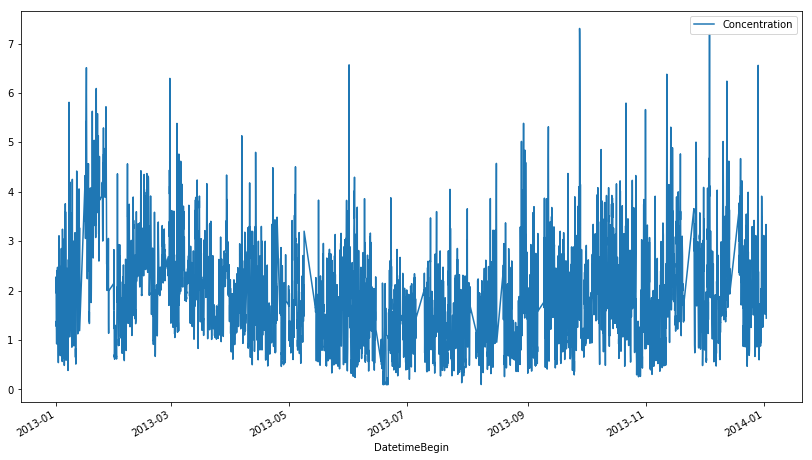

In [21]:
df.loc['SPO.DE_DESN025_CHB_dataGroup1', 'C6H6'][:'2014-01-01'].plot(y='Concentration', figsize=(14,8))